In [91]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install deepface

In [4]:
from deepface.commons import functions, distance as dst
import matplotlib.pyplot as plt

## Build ArcFace Model

In [11]:
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io
import tensorflow
from tensorflow import keras

import os
from pathlib import Path
import gdown

#url = "https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY"

def loadModel(url = 'https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5'):
	base_model = ResNet34()
	inputs = base_model.inputs[0]
	arcface_model = base_model.outputs[0]
	arcface_model = keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
	arcface_model = keras.layers.Dropout(0.4)(arcface_model)
	arcface_model = keras.layers.Flatten()(arcface_model)
	arcface_model = keras.layers.Dense(512, activation=None, use_bias=True, kernel_initializer="glorot_normal")(arcface_model)
	embedding = keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5, name="embedding", scale=True)(arcface_model)
	model = keras.models.Model(inputs, embedding, name=base_model.name)

	#---------------------------------------
	#check the availability of pre-trained weights

	home = str(Path.home())

	file_name = "arcface_weights.h5"
	output = "/content/aa/arcface_weights.h5"

	if os.path.isfile(output) != True:

		print(file_name," will be downloaded to ",output)
		gdown.download(url, "/content/aa/arcface_weights.h5", quiet=False)

	#---------------------------------------
	
	model.load_weights(output)

	return model

def ResNet34():

	img_input = tensorflow.keras.layers.Input(shape=(112, 112, 3))

	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = tensorflow.keras.layers.Conv2D(64, 3, strides=1, use_bias=False, kernel_initializer='glorot_normal', name='conv1_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = tensorflow.keras.layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)

	model = training.Model(img_input, x, name='ResNet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = tensorflow.keras.layers.Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = tensorflow.keras.layers.Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = tensorflow.keras.layers.PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = tensorflow.keras.layers.Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = tensorflow.keras.layers.Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

In [119]:
model = loadModel()

In [120]:
#Ref: https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY
model.load_weights("/content/aa/arcface_weights.h5")

In [24]:
print("ArcFace expects ",model.layers[0].input_shape[0][1:]," inputs")
print("and it represents faces as ", model.layers[-1].output_shape[1:]," dimensional vectors")

ArcFace expects  (112, 112, 3)  inputs
and it represents faces as  (512,)  dimensional vectors


In [36]:
target_size = model.layers[0].input_shape[0][1:3]
target_size

(112, 112)

## Early Stages of Pipeline

A modern face recognition pipeline consists of 4 common stages: detect, align, represent and verify. ArcFace model handles representation. Here, we will apply detection and alignment within deepface.

**Blog post:** [A Modern Face Recognition Pipeline](https://sefiks.com/2020/05/01/a-gentle-introduction-to-face-recognition-in-deep-learning/)

**Vlog:** [How Face Recognition Works with Deep Learning in Python](https://youtu.be/OYialFo7Qo4)

In [47]:
img1_path = "/content/1.jpg"
img2_path = "/content/right_face_3.jpg"
img3_path = "/content/left_face_3.jpg"
img4_path = '/content/right_face_153.jpg'
img5_path = '/content/left_face_153.jpg'


In [38]:
from PIL import Image
import numpy as np

img = Image.open(img1_path)
img = np.array(img)
img.shape

(112, 112, 3)

In [48]:
detector_backend = 'opencv'

img1 = functions.preprocess_face(img1_path, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)
img2 = functions.preprocess_face(img2_path, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)
img3 = functions.preprocess_face(img3_path, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)
img4 = functions.preprocess_face(img4_path, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)
img5 = functions.preprocess_face(img5_path, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)


In [ ]:
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1,6,1)
plt.axis('off')
plt.imshow(img1[0][:,:,::-1])

ax1 = fig.add_subplot(1,6,2)
plt.axis('off')
plt.imshow(img2[0][:,:,::-1])

ax1 = fig.add_subplot(1,6,3)
plt.axis('off')
plt.imshow(img3[0][:,:,::-1])


plt.show()

## Represent and verify

ArcFace is responsible for representing faces as 512 dimensional vectors

We will find distance between embeddings to verify they are same person or different persons

In [69]:
import torch
from torch.nn import functional as F

In [42]:
metric = 'cosine'

In [43]:
def findThreshold(metric):
    if metric == 'cosine':
        return 0.6871912959056619
    elif metric == 'euclidean':
        return 4.1591468986978075
    elif metric == 'euclidean_l2':
        return 1.1315718048269017

In [128]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

# 코사인 유사도 함수 
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

def verify(img1, img2):
    
    #representation
    
    img1_embedding = model.predict(img1)[0]
    img2_embedding = model.predict(img2)[0]
    img1_tensor = torch.unsqueeze(torch.tensor(img1_embedding), dim = 0)
    img2_tensor = torch.unsqueeze(torch.tensor(img2_embedding), dim = 0)
    sim = F.cosine_similarity(img1_tensor, img2_tensor)
    # if metric == 'cosine':
    #     distance = dst.findCosineDistance(img1_embedding, img2_embedding)
    # elif metric == 'euclidean':
    #     distance = dst.findEuclideanDistance(img1_embedding, img2_embedding)
    # elif metric == 'euclidean_l2':
    #     distance = dst.findEuclideanDistance(dst.l2_normalize(img1_embedding), dst.l2_normalize(img2_embedding))
    
    #------------------------------
    #verification
    
    # threshold = findThreshold(metric)
    
    # if distance <= threshold:
    #     print("they are same person")
    # else:
    #     print("they are different persons")
    
    # print("Distance is ",round(distance, 2)," whereas as expected max threshold is ",round(threshold, 2))
    
    return sim
    

In [129]:
import pandas as pd
import tqdm
submission = pd.read_csv("/content/sample_submission.csv")

left_test_paths = list()
right_test_paths = list()

for i in range(len(submission)):
    left_test_paths.append(submission['face_images'][i].split()[0])
    right_test_paths.append(submission['face_images'][i].split()[1])

In [130]:
results = []

for left_test_path, right_test_path in tqdm.tqdm(zip(left_test_paths, right_test_paths)):
    img_left = Image.open("/content/gdrive/MyDrive/test/" + left_test_path + '.jpg').convert("RGB")# 경로 설정 유의(ex .inha/test)
    img_left = np.array(img_left)
    img_left = functions.preprocess_face(img_left, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)
    img_right = Image.open("/content/gdrive/MyDrive/test/" + right_test_path + '.jpg').convert("RGB")# 경로 설정 유의(ex .inha/test)
    img_right = np.array(img_right)
    img_right = functions.preprocess_face(img_right, target_size = target_size, detector_backend = detector_backend, enforce_detection = False)
    results.append(verify(img_left, img_right))

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/deepface/commons/functions.py:69: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if len(img) > 11 and img[0:11] == "data:image/":
6000it [11:55,  8.39it/s]


In [135]:
temp = []
for i in results:
  temp.append(float(i))

In [137]:

submission = pd.read_csv("/content/sample_submission.csv") 
submission['answer'] = temp
submission.to_csv('/content/gdrive/MyDrive/pytorch_submission.csv', index=False)

they are different persons
Distance is  4.91  whereas as expected max threshold is  4.16


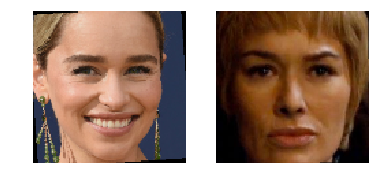

In [ ]:
verify(img4, img6)